#### Projeto C318 - Detecção de Fraudes em Cartões Bancários


#### Conjunto de Dados

#### Utilização do Isolation Forest Para isolar as Possíveis Anomalias

In [20]:
!pip install pandas scikit-learn
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Bibliotecas

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

#### Manipulação dos dados

In [22]:
# Carregar o conjunto de dados
df = pd.read_csv("creditcard.csv")

# Selecionar as colunas de features e a coluna de classe
X = df.drop(columns=['Class'])
y = df['Class']

#### Pré-processamento dos dados

In [23]:
# Aplicar PCA para reduzir para 20 componentes principais
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Adicionar os componentes principais ao DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

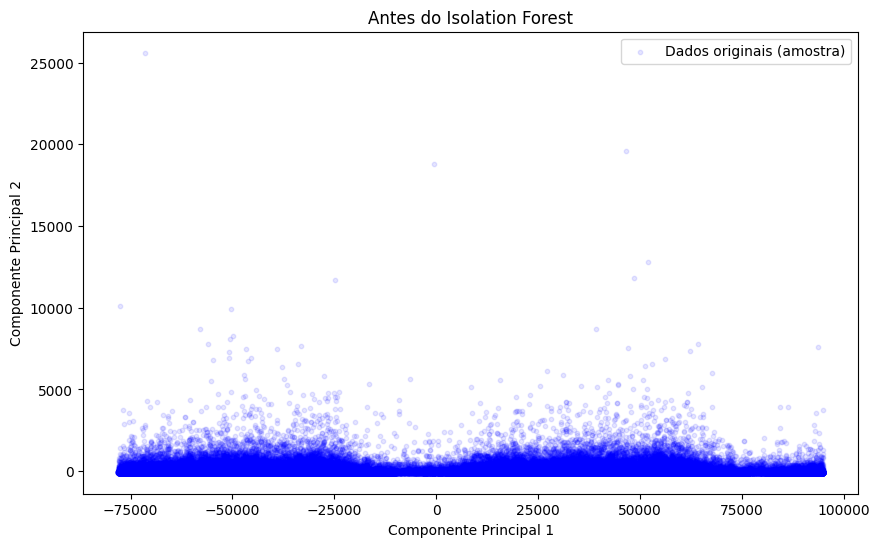

In [24]:
#Plot antes do Isolation Forest
plt.figure(figsize=(10, 6))
plt.scatter(df['PCA1'], df['PCA2'], c='blue', alpha=0.1, s=10, label="Dados originais (amostra)")
plt.title("Antes do Isolation Forest")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

#### Etapa 1: Isolar os Outliers com o Isolation Forest

In [25]:
# Etapa 1: Detecção de anomalias com Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_pca)

# Adicionar os rótulos de anomalia ao dataframe original
df['anomaly'] = anomaly_labels

#Dados Normais
normal = df[df['anomaly'] == 1]
# Selecionar apenas os outliers detectados (anomaly == -1)
outliers = df[df['anomaly'] == -1]
X_outliers = outliers.drop(columns=['Class', 'anomaly'])
y_outliers = outliers['Class']  # Classes reais dos outliers

#### Avaliação do Isolation Forest

In [26]:
# Calcular Precisão e Revocação
TP = ((df['anomaly'] == -1) & (df['Class'] == 1)).sum()   # Verdadeiros Positivos
FP = ((df['anomaly'] == -1) & (df['Class'] == 0)).sum()   # Falsos Positivos
FN = ((df['anomaly'] == 1) & (df['Class'] == 1)).sum()  # Falsos Negativos

precisionISO = TP / (TP + FP) if (TP + FP) > 0 else 0
recallISO = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Precisão somente com o Isolation Forest: {precisionISO:.2f}")
print(f"Revocação somente com o Isolation Forest: {recallISO:.2f}")

Precisão somente com o Isolation Forest: 0.07
Revocação somente com o Isolation Forest: 0.85


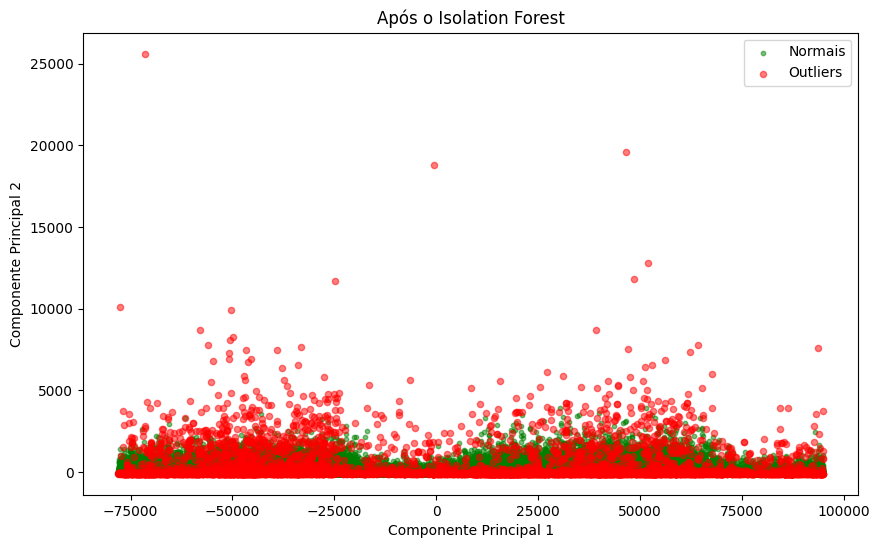

In [27]:
# Plot após o Isolation Forest
plt.figure(figsize=(10, 6))
plt.scatter(normal['PCA1'], normal['PCA2'], c='green', alpha=0.5, s=10, label="Normais")
plt.scatter(outliers['PCA1'], outliers['PCA2'], c='red', alpha=0.5, s=20, label="Outliers")
plt.title("Após o Isolation Forest")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

#### Etapa 2: Treinar o classificador para os Outliers que passaram pelo Isolation Forest

In [28]:
# Etapa 2: Treinamento do Classificador Supervisionado
# Dividir os dados de outliers em conjunto de treino e teste
outliers_data = df[df['anomaly'] == -1]
X_train, X_test, y_train, y_test = train_test_split(X_outliers, y_outliers, test_size=0.3, random_state=42)

# Treinar um classificador supervisionado (Random Forest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

#### Avaliação do Classificador (Trata-se do Random Forest)

In [29]:
# Calcular métricas de avaliação
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Resultados
print(f"Precisão após classificador supervisionado: {precision:.2f}")
print(f"Revocação após classificador supervisionado: {recall:.2f}")

Precisão após classificador supervisionado: 0.96
Revocação após classificador supervisionado: 0.92


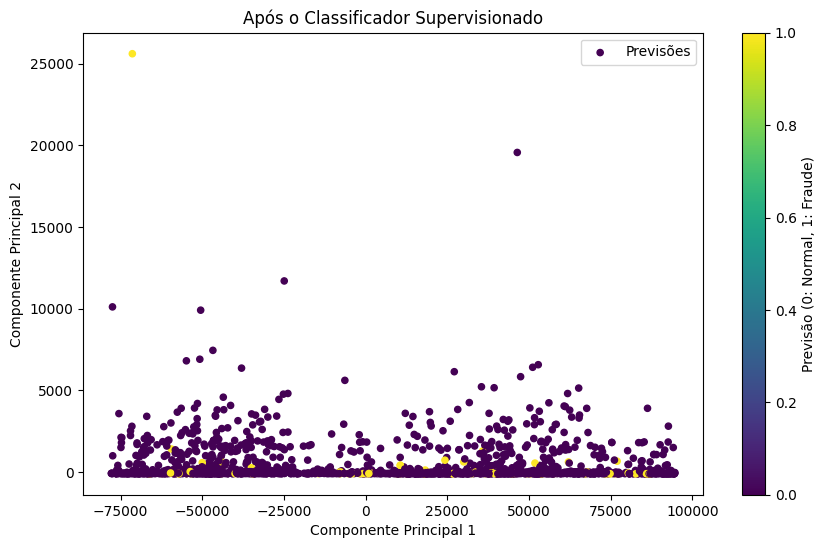

In [30]:
# Adicionar os resultados ao DataFrame para plotagem
test_results = X_test.copy()
test_results['Class'] = y_test
test_results['Prediction'] = y_pred

# Plot após o Classificador Supervisionado
plt.figure(figsize=(10, 6))
plt.scatter(test_results['PCA1'], test_results['PCA2'], c=test_results['Prediction'], cmap='viridis', s=20, label="Previsões")
plt.title("Após o Classificador Supervisionado")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Previsão (0: Normal, 1: Fraude)")
plt.legend()
plt.show()